# Using HMC to sample the inducing points

- Pure MCMC on all the training points is a problem due to the high correlations between them.
- Variational Inference does a poor job at properly modelling uncertainty - often I find points that are overly confident.
   - Although I wonder if this was due to insufficient inducing points?
   - I also noticed this was more a problem when the two latent functions had different lengthscales? Maybe the underlying distribution became less Gaussian or more correlated?

Here we use HMC to sample the values of the inducing points.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = []
Y = []

def gettruepol(x):
    return x[:,0:1]*5+5+((np.sin(x[:,1:]/2)+1)*((50-x[:,1:])/30)).astype(np.float32)

N = 1000
x = np.sort(np.random.rand(N)*50).astype(np.float32)[:,None]
x[x>10]+=10
x = np.c_[np.zeros(len(x)),x]
x[500:,0]=1
f = gettruepol(x)
y = (np.random.randn(N,1)/10+f*1.2).astype(np.float32)
X.append(x)
Y.append(y)

#REFERENCE INSTRUMENT: STILL NOISY?
N = 400
x = np.sort(np.random.rand(N)*50).astype(np.float32)[:,None]
x = np.c_[np.zeros(len(x)),x]
f = gettruepol(x)
y = (np.random.randn(N,1)/10+f).astype(np.float32)
X.append(x)
Y.append(y)

N = 200
x = np.sort(np.random.rand(N)*40).astype(np.float32)[:,None]
x = np.c_[np.ones(len(x)),x]
f = gettruepol(x)
y = (np.random.randn(N,1)/10+f*0.5).astype(np.float32)
X.append(x)
Y.append(y)

Mu = 20 #number of inducing points
Mv = 5
zu = np.linspace(0,80,Mu,dtype=np.float32)[:,None]
zv = np.linspace(0,80,Mv,dtype=np.float32)[:,None]

L = 2 #number of locations
S = len(X) #number of sensors
refsensors = [False,True,False]

In [3]:
u = []
for i in range(L):
    u.append(tf.Variable(np.random.randn(1,len(zu)),dtype=tf.float32))

v = []
for i in range(S):
    v.append(tf.Variable(0.1*np.random.randn(1,len(zv)),dtype=tf.float32))

likelihoodvariance=0.01

ku = psd_kernels.ExponentiatedQuadratic(length_scale=6.0,amplitude=2.0)+psd_kernels.Linear(bias_variance=1.0,slope_variance=0,)
kv = psd_kernels.ExponentiatedQuadratic(length_scale=20.0,amplitude=2.0)

uKzzinvKzxs = []
vKzzinvKzxs = []
for x in X:
    uKzzinvKzxs.append(tf.linalg.solve(ku.matrix(zu,zu),ku.matrix(zu,x[:,1:])))
    vKzzinvKzxs.append(tf.linalg.solve(kv.matrix(zv,zv),kv.matrix(zv,x[:,1:])))
#varu = tf.reduce_sum(ku.matrix(zu,x)*tf.linalg.solve(ku.matrix(zu,zu),ku.matrix(zu,x)),0)[:,None]
#varv = tf.reduce_sum(kv.matrix(zv,x)*tf.linalg.solve(kv.matrix(zv,zv),kv.matrix(zv,x)),0)[:,None]
gpzu = tfd.GaussianProcess(ku, zu)
gpzv = tfd.GaussianProcess(kv, zv)
#stdu = tf.sqrt(varu+likelihoodvariance)

In [4]:
@tf.function
def model_log_prob(*args):
    
    """Returns log probability of data given model"""
    #u = tf.concat([u1,u2],0)
    Us = args[:L]
    U = tf.concat(Us,0)
    Vs = args[L:]
    logp = 0
    for uKzzinvKzx,vKzzinvKzx,x,y,v,ref in zip(uKzzinvKzxs,vKzzinvKzxs,X,Y,Vs,refsensors):
        allpollutions = tf.transpose(uKzzinvKzx)@tf.transpose(U)
        sensorpol = tf.exp(tf.gather_nd(allpollutions,np.c_[np.arange(len(x)),x[:,0].astype(int)])[:,None])
        if ref:
            mean = sensorpol
        else:
            mean = sensorpol / tf.exp(tf.transpose(vKzzinvKzx)@tf.transpose(v))
        #var = tf.reduce_sum(k.matrix(z,x)*tf.linalg.solve(k.matrix(z,z),k.matrix(z,x)),0)[:,None]
        
        logp+=tf.reduce_sum(tfd.Normal(mean,1.0).log_prob(y))
    for u in Us:
        logp+=gpzu.log_prob(u) #prior
    for v in Vs:
        logp+=gpzv.log_prob(v) #prior

    return logp


In [9]:
num_results = 1000
num_burnin_steps = 10000
initial_chain_states = u+v #[u1,u2,v1,v2]
kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=model_log_prob,
            step_size=np.float64(0.003),
            num_leapfrog_steps=10)

# Perform HMC in a 'decorrelated' space
#kernel = tfp.mcmc.TransformedTransitionKernel(
#    inner_kernel=kernel,
#    bijector=tfp.bijectors.AffineLinearOperator(
#        scale=tf.linalg.LinearOperatorLowerTriangular(
#            tf.linalg.cholesky(
#                ku.matrix(zu,zu)
#            + (1e-4 + 1e-6) * tf.eye(len(zu), dtype=np.float32))
#        )))

# Perform HMC in a 'decorrelated' space

bijector = []
for i in range(L):
    bijector.append(tfp.bijectors.AffineLinearOperator(
        scale=tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(ku.matrix(zu,zu) + (1e-4 + 1e-6) * tf.eye(len(zu), dtype=np.float32))))
    )
    
for i in range(S):
    bijector.append(tfp.bijectors.AffineLinearOperator(
        scale=tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(kv.matrix(zv,zv) + (1e-4 + 1e-6) * tf.eye(len(zv), dtype=np.float32))))
    )

kernel = tfp.mcmc.TransformedTransitionKernel(inner_kernel=kernel,bijector=bijector)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8), target_accept_prob=np.float64(0.75))
from time import time

@tf.function
def run_mcmc():
    preds, kernel_results = tfp.mcmc.sample_chain(num_steps_between_results=50,
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_states,
        kernel=kernel)
    return preds, kernel_results

start = time()
preds, kernel_results = run_mcmc()
print("Time: %0.2f" % (time()-start))
#print(np.mean(kernel_results.inner_results.is_accepted))
print(np.mean(kernel_results.inner_results.inner_results.is_accepted))

/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Time: 359.60
0.798


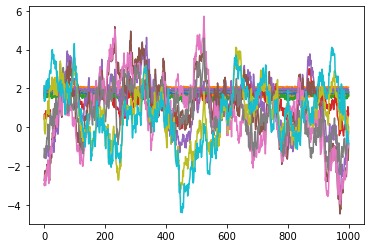

In [10]:
plt.plot(preds[0][:,0,:]);

In [11]:
xtest = np.linspace(0,80,101)[:,None]
uKzzinvKzxtest = tf.linalg.solve(ku.matrix(zu,zu)+tf.eye(len(zu))*1e-3,ku.matrix(zu,xtest))
vKzzinvKzxtest = tf.linalg.solve(kv.matrix(zv,zv)+tf.eye(len(zv))*1e-3,kv.matrix(zv,xtest))
#mean = k.matrix(xtest,z)@tf.linalg.inv(k.matrix(z,z))@tf.transpose(preds[0][:,0,:])
meanu0 = tf.transpose(uKzzinvKzxtest)@tf.transpose(preds[0][:,0,:])
meanu1 = tf.transpose(uKzzinvKzxtest)@tf.transpose(preds[1][:,0,:])
meanv0 = tf.transpose(vKzzinvKzxtest)@tf.transpose(preds[2][:,0,:])
meanv1 = tf.transpose(vKzzinvKzxtest)@tf.transpose(preds[3][:,0,:])
meanv2 = tf.transpose(vKzzinvKzxtest)@tf.transpose(preds[4][:,0,:])
#cov = k.matrix(xtest,xtest)-k.matrix(xtest,z)@tf.linalg.inv(k.matrix(z,z))@k.matrix(z,xtest)
#likelihoodvariance=1e-0
#pfu = tfd.MultivariateNormalFullCovariance(tf.transpose(mean),cov+likelihoodvariance*tf.eye(len(xtest)))

The reference instrument is running at location 0,
so our estimates of the pollution and the observations match

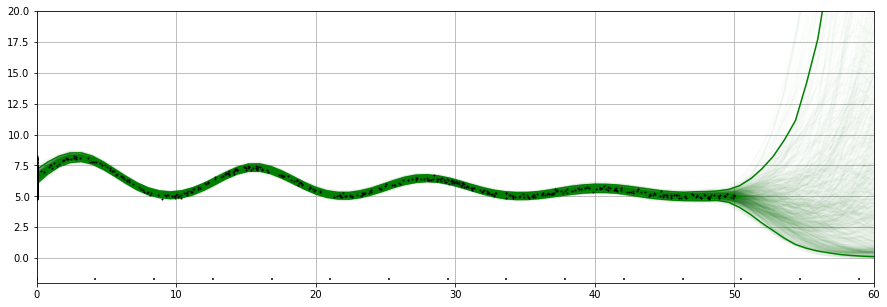

In [21]:
plt.figure(figsize=[15,5])
#plt.plot(xtest,tf.exp(meanu1),'b-',alpha=0.05);
#plt.plot(xtest,meanv,'b--',alpha=0.01);
#plt.plot(xtest,tf.exp(meanu0)/tf.exp(meanv0),'k-',alpha=0.01);
plt.plot(xtest,tf.exp(meanu0),'g-',alpha=0.01);
plt.plot(xtest,np.sort(tf.exp(meanu0))[:,[int(num_results*0.025),int(num_results*0.975)]],'g-')

x = X[1]
y = Y[1]
plt.plot(x,y,'.k',markersize=2)
plt.xlim([0,60])
plt.ylim([-2,20])
plt.grid()
plt.vlines(zu,-1.8,-1.6)

The scaling of the mobile sensor is quite confident in those periods when
it is co-localised with the reference instrument.

The black lines indicate the times when observations were taken in location 0 by the mobile sensor:


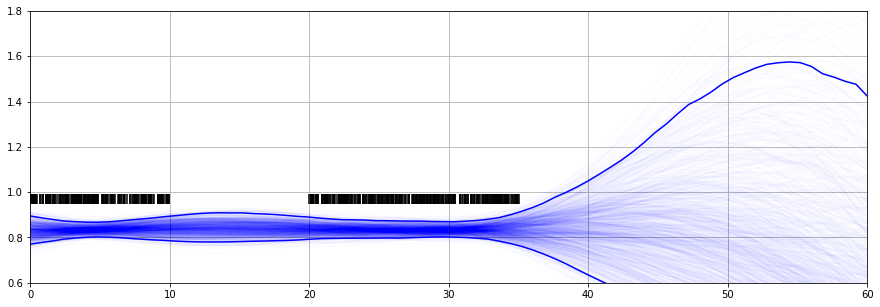

In [22]:
plt.figure(figsize=[15,5])
#plt.plot(xtest,tf.exp(meanu1),'b-',alpha=0.05);
#plt.plot(xtest,meanv,'b--',alpha=0.01);
plt.plot(xtest,tf.exp(meanv0),'b-',alpha=0.01);
plt.plot(xtest,np.sort(tf.exp(meanv0))[:,[int(num_results*0.025),int(num_results*0.975)]],'b-')

#plt.plot(xtest,np.sort(tf.exp(meanv0))[:,[int(num_results*0.025),int(num_results*0.975)]],'b-')
x = X[0]
y = Y[0]
plt.vlines(x[x[:,0]==0],0.95,0.99)
plt.xlim([0,60])
plt.ylim([0.6,1.8])
plt.grid()
plt.vlines(zu,-1.8,-1.6)

The static instrument at location 1 has the greatest confidence in its uncertainty when the
mobile sensor has just arrived. At this point the mobile sensor is still quite confident about
its own calibration & so can pass on that confidence.

The black lines indicate the times when observations were taken in location 1 by the mobile sensor:


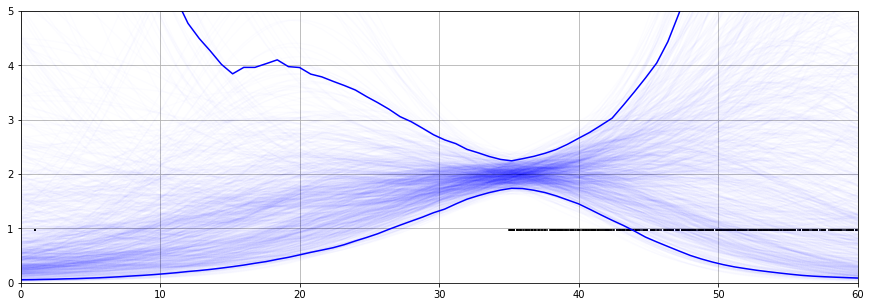

In [23]:
plt.figure(figsize=[15,5])
#plt.plot(xtest,tf.exp(meanu1),'b-',alpha=0.05);
#plt.plot(xtest,meanv,'b--',alpha=0.01);
plt.plot(xtest,tf.exp(meanv2),'b-',alpha=0.01);
plt.plot(xtest,np.sort(tf.exp(meanv2))[:,[int(num_results*0.025),int(num_results*0.975)]],'b-')
#plt.plot(xtest,np.sort(tf.exp(meanv0))[:,[int(num_results*0.025),int(num_results*0.975)]],'b-')
x = X[0]
y = Y[0]
plt.vlines(x[x[:,0]==1],0.95,0.99)
plt.xlim([0,60])
plt.ylim([0,5])
plt.grid()

This leads to inevitably a more confident patch just around the time when the mobile sensor arrives.

The vertical ticks indicate observations of the two sensors.

The black line is the true pollution.

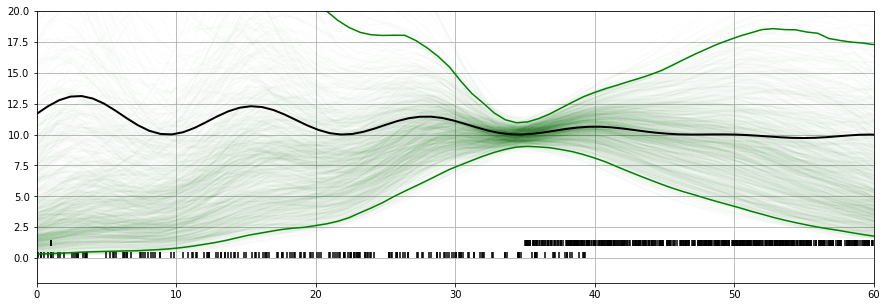

In [24]:
plt.figure(figsize=[15,5])
#plt.plot(xtest,tf.exp(meanu1),'b-',alpha=0.05);
#plt.plot(xtest,meanv,'b--',alpha=0.01);
plt.plot(xtest,tf.exp(meanu1),'g-',alpha=0.01);
plt.plot(xtest,np.sort(tf.exp(meanu1))[:,[int(num_results*0.025),int(num_results*0.975)]],'g-')

plt.ylim([-2,20])
plt.xlim([0,60])
plt.grid()
x = X[0]
y = Y[0]
plt.vlines(x[x[:,0]==1],1,1.5)
x = X[2]
y = Y[2]
plt.vlines(x,0,0.5)

x = np.c_[np.ones(100),np.linspace(0,80,100)]
f  =gettruepol(x)
plt.plot(x[:,1],f,'k-',lw=2)